In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [3]:
path = untar_data(URLs.MNIST)
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/testing'),
 PosixPath('/root/.fastai/data/mnist_png/training')]

In [0]:
il = ImageList.from_folder(path, convert_mode='L')

In [5]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/testing/5/1406.png')

In [0]:
defaults.cmap = 'binary'

In [7]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

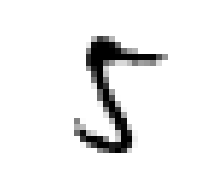

In [8]:
il[0].show()

In [9]:
sd = il.split_by_folder(train='training', valid='testing')
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [10]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/7')]

In [11]:
l1 = sd.label_from_folder()
l1

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
5,5,5,5,5
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
5,5,5,5,5
Path: /root/.fastai/data/mnist_png;

Test: None

5 torch.Size([1, 28, 28])


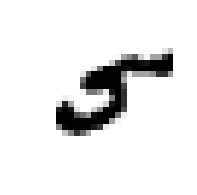

In [12]:
x, y = l1.train[0]
x.show()
print(y, x.shape)

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [0]:
l1 = l1.transform(tfms)

In [0]:
bs = 128

In [0]:
data = l1.databunch(bs=bs).normalize()

5


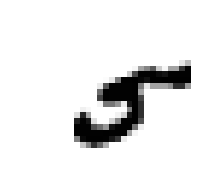

In [18]:
x, y = data.train_ds[0]
x.show()
print(y)

In [0]:
def _plot(i, j, ax):
    data.train_ds[0][0].show(ax, cmpa='gray')

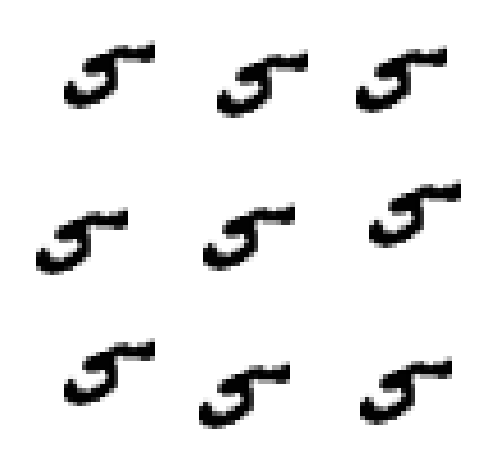

In [20]:
plot_multi(_plot, 3, 3, figsize=(8, 8))

In [21]:
xb, yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

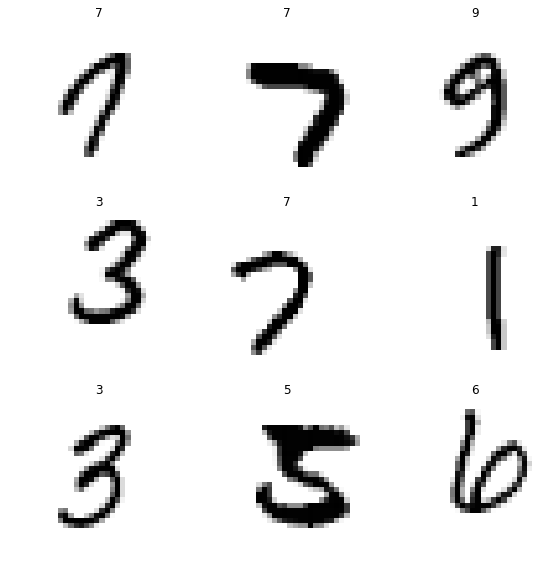

In [22]:
data.show_batch(rows=3, figsize=(8, 8))

In [0]:
def conv(ni, nf):
    return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)


In [0]:
model = nn.Sequential(
    conv(1, 8),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [28]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
______________________________________________________________

In [30]:
xb = xb.cuda()
model(xb).shape

torch.Size([128, 10])

In [31]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


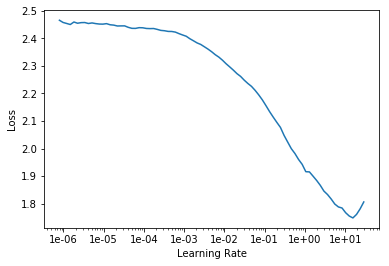

In [32]:
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.239874,0.230196,0.929800,00:26
1,0.138765,0.115438,0.964100,00:25
2,0.078018,0.036285,0.987900,00:24


In [0]:
def conv2(ni, nf):
    return conv_layer(ni, nf, stride=2)


In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),   # 7
    conv2(16, 32),   # 4
    conv2(32, 16),   # 2
    conv2(16, 10),   # 1
    Flatten()        # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


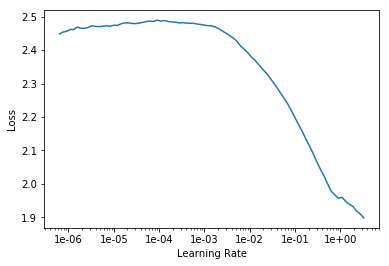

In [46]:
learn.recorder.plot(skip_start=10)

In [47]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.243828,0.582567,0.830900,00:26
1,0.200929,0.202025,0.938600,00:25
2,0.163563,0.126889,0.958600,00:25
3,0.131042,0.208946,0.935200,00:26
4,0.134069,0.212356,0.932700,00:25
5,0.112565,0.062751,0.981100,00:26
6,0.084891,0.057327,0.982300,00:26
7,0.067874,0.040759,0.987000,00:26
8,0.058405,0.030785,0.988700,00:25
9,0.043091,0.028554,0.990200,00:26


In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf)
        
    def forward(self, x):
        return x + (self.conv2(self.conv1(x)))

In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
def conv_and_res(ni, nf):
    return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [53]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


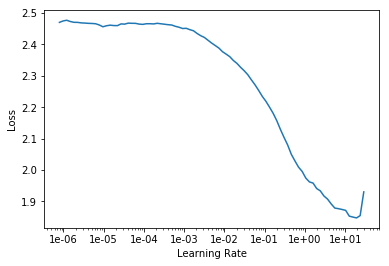

In [54]:
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.251764,0.236395,0.931900,00:28
1,0.146310,0.243783,0.923400,00:28
2,0.100408,0.096065,0.969600,00:29
3,0.092821,0.072865,0.976600,00:27
4,0.075120,0.056071,0.981700,00:29
5,0.061670,0.055100,0.983500,00:29
6,0.052318,0.052218,0.984200,00:29
7,0.045458,0.038115,0.987000,00:29
8,0.036940,0.034900,0.989600,00:30
9,0.031762,0.020088,0.993600,00:28


In [56]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________